# Data Preprocessing and Visualization for BISINDO Sign Language Dataset

This notebook documents the preprocessing and visualization workflow for the BISINDO sign language dataset. Below is a detailed explanation of each step:

## Importing Required Libraries
We start by importing necessary libraries for model building, training, and evaluation. These include TensorFlow for deep learning, scikit-learn for data handling, and visualization tools.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

2025-05-11 18:57:50.066251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 18:57:50.367647: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 18:57:50.625557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746964670.848317   98802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746964670.910207   98802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746964671.396669   98802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Setting Random Seeds
We set random seeds for both NumPy and TensorFlow to ensure reproducibility of results across different runs.

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

## Defining Paths
We define paths for accessing the processed data and saving the trained models. This helps organize our project structure.

In [5]:
PROCESSED_PATH = '../data/processed'
LANDMARKS_PATH = os.path.join(PROCESSED_PATH, 'landmarks')
MODELS_PATH = '../models'

## Creating Model Directory
We create a directory for storing trained models if it doesn't already exist.

In [6]:
os.makedirs(MODELS_PATH, exist_ok=True)

## Loading Metadata
We load the metadata created during preprocessing, which contains information about our samples including their classes and paths to landmark files.

In [8]:
metadata_path = os.path.join(PROCESSED_PATH, 'metadata.csv')
df = pd.read_csv(metadata_path)

print(f"Total samples: {len(df)}")
print(f"Number of classes: {df['class'].nunique()}")
print(f"Classes: {df['class'].unique()}")

Total samples: 18000
Number of classes: 6
Classes: ['Bertemu' 'Halo' 'Kamu' 'Perkenalkan' 'Saya' 'Senang']


## Encoding Class Labels
We use a LabelEncoder to convert textual class labels into numerical values that can be used by the machine learning model.

In [9]:
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

## Saving Class Mappings
We save the label encoder's class mappings to a file, which will be needed later for interpreting model predictions during evaluation and inference.

In [10]:
np.save(os.path.join(MODELS_PATH, 'classes.npy'), label_encoder.classes_)
print(f"Class mapping saved to {os.path.join(MODELS_PATH, 'classes.npy')}")

Class mapping saved to ../models/classes.npy


## Defining Data Loading Function
We create a function to load and preprocess landmark data from files. This function handles various transformations needed to prepare the data for the model, including reshaping, normalization, and sequence padding.

In [11]:
def load_data(dataframe, max_frames=100, num_landmarks=33, num_dimensions=3):
    """
    Load and preprocess landmark data from files referenced in the dataframe.
    
    Args:
        dataframe: Pandas DataFrame containing metadata about the samples
        max_frames: Maximum number of frames to keep (for padding/truncating)
        num_landmarks: Number of landmarks in each frame
        num_dimensions: Number of dimensions for each landmark (usually 3 for x,y,z)
        
    Returns:
        X: Array of landmark features
        y: Array of class labels
    """
    X = []
    y = []
    
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Loading data"):
        try:
            # Load landmarks data
            landmarks = np.load(row['landmark_path'])
            
            # Handle different possible data shapes
            if landmarks.ndim == 1:
                # If data is flat, attempt to reshape
                landmarks = landmarks.reshape(1, -1)
            
            # Ensure landmarks have consistent dimensions
            if landmarks.shape[1] != num_landmarks * num_dimensions:
                # If dimensions don't match, reshape or skip
                if landmarks.shape[1] % num_dimensions == 0:
                    new_num_landmarks = landmarks.shape[1] // num_dimensions
                    landmarks = landmarks.reshape(landmarks.shape[0], new_num_landmarks, num_dimensions)
                else:
                    print(f"Skipping sample with incompatible shape: {landmarks.shape}")
                    continue
            else:
                # Reshape to (frames, landmarks, dimensions)
                landmarks = landmarks.reshape(landmarks.shape[0], num_landmarks, num_dimensions)
            
            # Normalize coordinates to [0, 1] range
            for i in range(num_dimensions):
                min_val = np.min(landmarks[:, :, i])
                max_val = np.max(landmarks[:, :, i])
                if max_val > min_val:
                    landmarks[:, :, i] = (landmarks[:, :, i] - min_val) / (max_val - min_val)
            
            # Handle sequence length (padding or truncating)
            if landmarks.shape[0] > max_frames:
                # Truncate if too long
                landmarks = landmarks[:max_frames]
            elif landmarks.shape[0] < max_frames:
                # Pad with zeros if too short
                padding = np.zeros((max_frames - landmarks.shape[0], landmarks.shape[1], landmarks.shape[2]))
                landmarks = np.vstack([landmarks, padding])
            
            # Reshape to the format expected by the model
            landmarks = landmarks.reshape(max_frames, -1)  # Flatten landmarks and dimensions
            
            X.append(landmarks)
            y.append(row['class_encoded'])
            
        except Exception as e:
            print(f"Error processing {row['landmark_path']}: {e}")
    
    return np.array(X), np.array(y)

## Setting Landmark Parameters
We define key parameters for processing the landmark data, including maximum frames per sample, number of landmarks, and dimensions per landmark.

In [12]:
MAX_FRAMES = 100  # Maximum number of frames per sample
NUM_LANDMARKS = 33  # MediaPipe typically uses 33 landmarks for pose
NUM_DIMENSIONS = 3  # x, y, z coordinates

## Loading and Preprocessing Data
We load the landmark data using our defined function, converting the metadata references into properly formatted numpy arrays for training.

In [13]:
X, y = load_data(df, max_frames=MAX_FRAMES, num_landmarks=NUM_LANDMARKS, num_dimensions=NUM_DIMENSIONS)

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Loading data: 100%|██████████| 18000/18000 [00:22<00:00, 789.22it/s]


Data shape: (18000, 100, 126)
Labels shape: (18000,)


## Splitting the Dataset
We split our data into training, validation, and test sets to properly evaluate model performance and prevent overfitting.

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (12600, 100, 126), (12600,)
Validation set: (2700, 100, 126), (2700,)
Test set: (2700, 100, 126), (2700,)


## Defining Model Architecture
We create a function that builds and compiles a sequential model with a combination of Conv1D and LSTM layers, designed to capture both spatial and temporal patterns in the sign language gestures.

In [15]:
def create_model(input_shape, num_classes):
    """
    Create a sequential model for sign language recognition.
    
    Args:
        input_shape: Shape of input data (frames, features)
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = Sequential([
        # First Conv1D layer
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Second Conv1D layer
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # LSTM layers for sequence modeling
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        LSTM(128),
        Dropout(0.3),
        
        # Output layer
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Setting Input Shape and Classes
We determine the input shape for our model based on the training data dimensions, and set the number of output classes.

In [16]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_encoder.classes_)

## Building the Model
We create the model using our architecture function and display a summary of its structure and parameters.

In [17]:
model = create_model(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1746964750.640406   98802 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746964750.643155   98802 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 23, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649,734 (2.48 MB)

 Trainable params: 649,350 (2.48 MB)

 Non-trainable params: 384 (1.50 KB)

## Setting Up Callbacks
We set up callbacks for model training, including checkpoints to save the best model, early stopping to prevent overfitting, and learning rate reduction to optimize training.

In [18]:
callbacks = [
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        filepath=os.path.join(MODELS_PATH, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

## Training the Model
We train the model on our training data, validating on the validation set, for a specified number of epochs and batch size.

In [19]:
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

2025-05-11 18:59:22.322301: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 635040000 exceeds 10% of free system memory.


Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4862 - loss: 1.0677

2025-05-11 19:00:36.351818: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 136080000 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.65333, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 79s 185ms/step - accuracy: 0.4864 - loss: 1.0672 - val_accuracy: 0.6533 - val_loss: 0.6298 - learning_rate: 0.0010
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6418 - loss: 0.6819
Epoch 2: val_accuracy improved from 0.65333 to 0.80593, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 72s 182ms/step - accuracy: 0.6418 - loss: 0.6819 - val_accuracy: 0.8059 - val_loss: 0.5004 - learning_rate: 0.0010
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7469 - loss: 0.6034
Epoch 3: val_accuracy improved from 0.80593 to 0.81741, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - accuracy: 0.7469 - loss: 0.6034 - val_accuracy: 0.8174 - val_loss: 0.3234 - learning_rate: 0.0010
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8069 - loss: 0.3974
Epoch 4: val_accuracy improved from 0.81741 to 0.84667, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 74s 188ms/step - accuracy: 0.8069 - loss: 0.3973 - val_accuracy: 0.8467 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8261 - loss: 0.3967
Epoch 5: val_accuracy improved from 0.84667 to 0.94296, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 74s 187ms/step - accuracy: 0.8262 - loss: 0.3966 - val_accuracy: 0.9430 - val_loss: 0.1818 - learning_rate: 0.0010
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9102 - loss: 0.2737
Epoch 6: val_accuracy improved from 0.94296 to 0.98519, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - accuracy: 0.9101 - loss: 0.2737 - val_accuracy: 0.9852 - val_loss: 0.0739 - learning_rate: 0.0010
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9468 - loss: 0.1849
Epoch 7: val_accuracy improved from 0.98519 to 0.98741, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 71s 180ms/step - accuracy: 0.9468 - loss: 0.1849 - val_accuracy: 0.9874 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9601 - loss: 0.1473
Epoch 8: val_accuracy improved from 0.98741 to 0.98815, saving model to ../models/best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 84s 182ms/step - accuracy: 0.9601 - loss: 0.1473 - val_accuracy: 0.9881 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 9/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9413 - loss: 0.1931
Epoch 9: val_accuracy did not improve from 0.98815
394/394 ━━━━━━━━━━━━━━━━━━━━ 70s 177ms/step - accuracy: 0.9413 - loss: 0.1931 - val_accuracy: 0.9167 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 10/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9447 - loss: 0.1674
Epoch 10: val_accuracy did not improve from 0.98815
394/394 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - accuracy: 0.9447 - loss: 0.1674 - val_accuracy: 0.9730 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 11/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9549 - loss: 0.1515
Epoch 11: val_accuracy did not improve from 0.98815
394/394 ━━━━━━━━━━━━━━━━━━━━ 73s 185ms/step - accuracy: 0.9549 - loss: 0.1515 - val_accuracy: 0.9874 - val_loss: 0.0566 - learning_rate: 0.0010


394/394 ━━━━━━━━━━━━━━━━━━━━ 72s 183ms/step - accuracy: 0.9755 - loss: 0.0999 - val_accuracy: 0.9885 - val_loss: 0.0470 - learning_rate: 5.0000e-04
Epoch 21/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9750 - loss: 0.1021
Epoch 21: val_accuracy did not improve from 0.98852
394/394 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - accuracy: 0.9750 - loss: 0.1021 - val_accuracy: 0.9867 - val_loss: 0.0675 - learning_rate: 5.0000e-04
Epoch 22/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9768 - loss: 0.0888
Epoch 22: val_accuracy did not improve from 0.98852
394/394 ━━━━━━━━━━━━━━━━━━━━ 70s 176ms/step - accuracy: 0.9768 - loss: 0.0888 - val_accuracy: 0.9874 - val_loss: 0.0520 - learning_rate: 5.0000e-04
Epoch 23/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9783 - loss: 0.0907
Epoch 23: val_accuracy did not improve from 0.98852
394/394 ━━━━━━━━━━━━━━━━━━━━ 71s 181ms/step - accuracy: 0.9783 - loss: 0.0907 - val_accuracy: 0.9874 - val_loss: 0.0476 - learning

## Saving the Final Model
After training, we save the final model to disk for future use.

In [20]:
model.save(os.path.join(MODELS_PATH, 'final_model.h5'))
print(f"Model saved to {os.path.join(MODELS_PATH, 'final_model.h5')}")

Model saved to ../models/final_model.h5


## Preparing Visualization
We set up a figure for visualizing training metrics.

In [21]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

## Plotting Accuracy
We plot the training and validation accuracy across epochs to visualize how the model's accuracy improved during training.

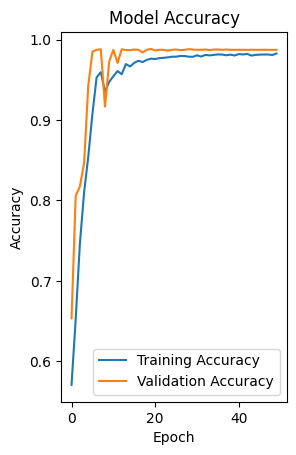

In [22]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Evaluating on Test Set
We evaluate the trained model on the test set to measure its final performance on unseen data.

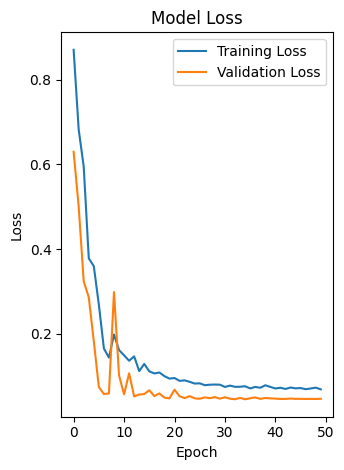

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

 2/85 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 1.0000 - loss: 0.0072

2025-05-11 20:07:50.621355: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 136080000 exceeds 10% of free system memory.


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9944 - loss: 0.0233
Test accuracy: 0.9911
Test loss: 0.0330


## Making Predictions
We use the model to make predictions on the test set, which will be used for detailed evaluation.

In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

2025-05-11 20:07:59.375094: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 136080000 exceeds 10% of free system memory.


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step


## Generating Classification Report
We create a classification report showing precision, recall, and F1 score for each class to understand model performance in detail.

In [26]:
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     Bertemu       1.00      0.98      0.99       450
        Halo       1.00      1.00      1.00       450
        Kamu       0.98      1.00      0.99       450
 Perkenalkan       1.00      0.99      0.99       450
        Saya       0.97      1.00      0.98       450
      Senang       1.00      0.97      0.98       450

    accuracy                           0.99      2700
   macro avg       0.99      0.99      0.99      2700
weighted avg       0.99      0.99      0.99      2700



## Creating Confusion Matrix
We generate and visualize a confusion matrix to see how well the model distinguishes between different classes and identify common misclassifications.

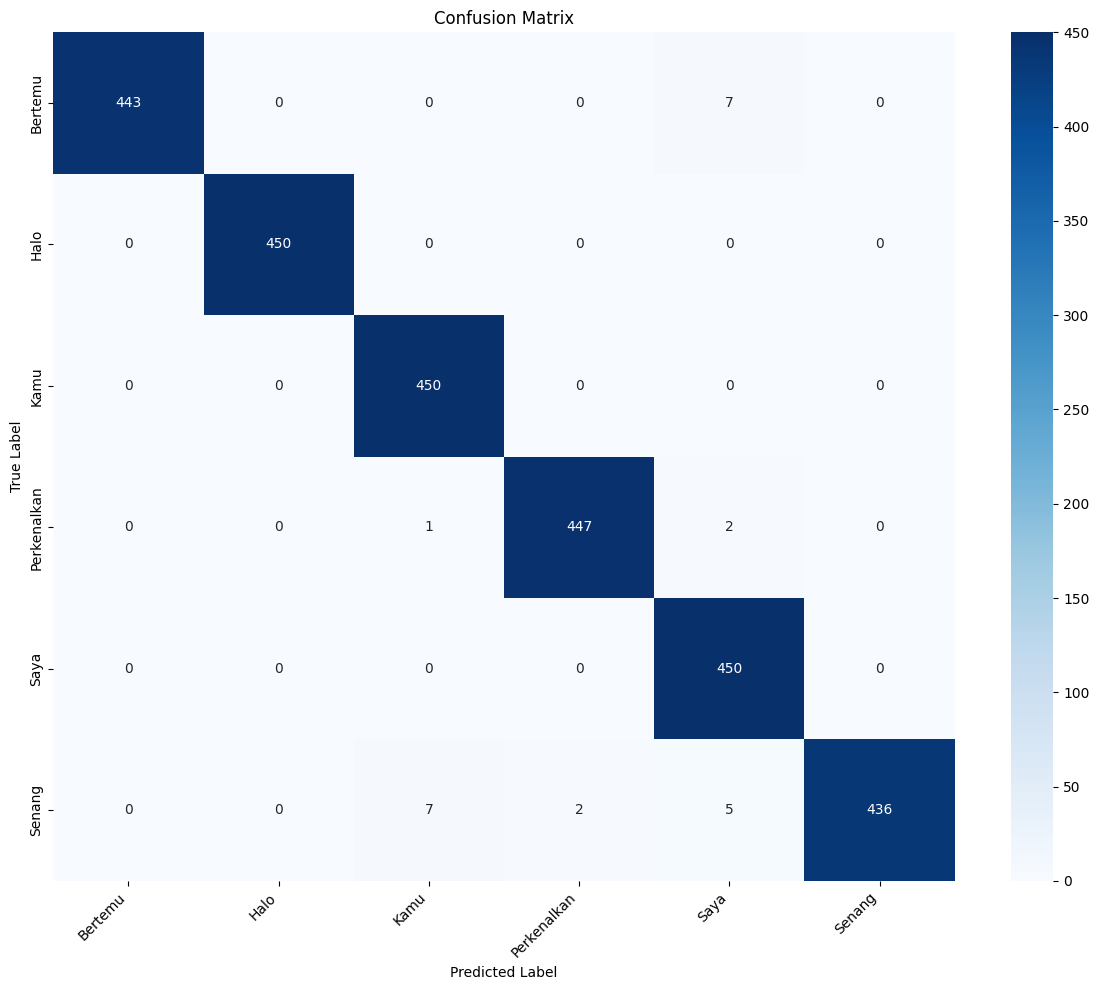

Model training completed successfully!


In [27]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Model training completed successfully!")